In [1]:
import sys
sys.path.append('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github')


In [ ]:

# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
# import math
import numpy as np
import pandas as pd
import random
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df

!pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristic import NumericHeuristic5
from pct.tree.splitter.splitter import Splitter
from pct.tree.tree import Tree

In [3]:
data = pd.read_csv("/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/ml-1m/ratings.txt",sep='::',index_col=False,names=["user_id","item_id","rating","timestamp"],header=None,engine='python')
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
# Iteratively filters out users and items with fewer than the threshold number of interactions until no changes happen.
data = threshold_interactions_df(data,'user_id','item_id',100,100)
matrix,rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid = df_to_matrix(data,"user_id","item_id","rating")

# split to train, X and eval sets
al,train,_ = train_test_split(matrix,1) # train_test_split(interactions, split_count, fraction=None)
# train: a matrix containing only the 1 held-out rating per user

# ml 1M
X_matrix,test,_ = train_test_split(al,30)
# test: a matrix containing only the 30 held-out ratings per user
# X: a matrix containing the rest of the ratings

Starting interactions info
Number of rows: 6040
Number of cols: 3706
Sparsity: 4.468%
Ending interactions info
Number of rows: 2828
Number of columns: 1919
Sparsity: 14.284%


In [4]:
def get_nodes_by_level(self, level):
    """
    Retrieve all nodes at a specific level with valid item IDs and their associated users.
    
    :param level: The depth level (0-indexed)
    :return: List of tuples (node, user_ids) where:
             - node.attribute_name is a valid integer item ID
             - user_ids is list of original user IDs in this node
    """
    if self.root is None:
        return []

    queue = [(self.root, 0)]
    valid_nodes = []

    while queue:
        node, current_level = queue.pop(0)

        if current_level == level:
            # Validation checks
            is_valid_item = isinstance(node.attribute_name, int)
            has_users = hasattr(node, 'user_ids') and len(node.user_ids) > 0
            is_internal_node = not node.is_leaf
            
            if all([is_valid_item, has_users, is_internal_node]):
                valid_nodes.append( (node, node.user_ids) )
                
        elif current_level < level:
            for child in node.children:
                if child is not None:
                    queue.append((child, current_level + 1))

    return valid_nodes


Original matrix
    ↓
    a matrix containing only the 1 held-out rating per user → train         (for initial model because we are simulating the "cold-start" or early-user scenario)
    Remaining → al
        ↓
        Split out 30 ratings → test    (for evaluation)
        Remaining → X_matrix           (for elicitation)


To explain the `get_nodes_by_level` function to someone who doesn't know coding, let’s break it down into simple concepts and analogies:

### Purpose of the Function
The function organizes all the nodes of a tree into groups based on their depth or level in the tree. Imagine a tree where each level represents a layer of branches, starting from the trunk (root) at level 0, then moving outward to higher levels. This function helps us collect all the nodes at each level into separate groups.

### Step-by-Step Explanation
1. **Start with the Root**:
   - Think of the root as the base of the tree (level 0). The function begins by focusing on this starting point.

2. **Create a Queue**:
   - Imagine you have a line (queue) of nodes waiting to be processed. The root node is added to this line first, along with its level (0).

3. **Process Each Node**:
   - The function takes one node at a time from the queue and checks which level it belongs to.
   - If this is the first time we’re seeing this level, we create a new group for it.

4. **Add Node to Its Group**:
   - Once we know which level the node belongs to, we add it to that group.

5. **Add Children to the Queue**:
   - Every node can have child nodes (branches growing out of it). The function adds these child nodes to the queue and assigns them to the next level (current level + 1).

6. **Repeat Until All Nodes Are Processed**:
   - The function keeps processing nodes from the queue until there are no more nodes left to process.

7. **Return Groups**:
   - At the end, we have a collection of groups where each group represents all the nodes at a specific level in the tree.




# Approach 1

In [5]:
x_df = matrix_to_full_df(train, idx_to_rid, idx_to_cid)
pct = Tree(max_depth=7)
pct.fit(x_df, x_df)

/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Initializing Splitter...
✅ Calling build()...
🔄 Recursively building tree for subsets...
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


🔄 Recursively building tree for subsets...
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


🔄 Recursively building tree for subsets...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


🔄 Recursively building tree for subsets...
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None
🔄 Recursively building tree for subsets...
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


🔄 Recursively building tree for subsets...
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 7. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 7. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 7. Stopping recursion.
Total Error (Criterion Value): None
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


🔄 Recursively building tree for subsets...
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


🔄 Recursively building tree for subsets...
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


🔄 Recursively building tree for subsets...
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 7. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 7. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 7. Stopping recursion.
Total Error (Criterion Value): None
✅ Tree built successfully!


In [6]:
pct.print_tree_structure()

Leaf Node: No
Depth: 0
Item_ID: 32
user_ids: [2, 5, 8, 9, 10, 11, 13, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 42, 44, 45, 48, 49, 53, 58, 59, 62, 65, 73, 75, 78, 82, 90, 92, 93, 97, 101, 102, 103, 107, 117, 118, 119, 123, 127, 129, 130, 131, 133, 134, 136, 137, 139, 146, 147, 148, 149, 150, 151, 156, 157, 161, 162, 163, 166, 169, 173, 175, 178, 179, 181, 186, 187, 190, 192, 193, 195, 198, 199, 202, 203, 204, 205, 208, 210, 212, 214, 216, 220, 223, 224, 225, 229, 230, 235, 237, 238, 240, 242, 245, 249, 255, 258, 259, 260, 261, 262, 264, 267, 268, 270, 271, 272, 273, 274, 278, 284, 285, 287, 293, 295, 300, 301, 302, 303, 305, 306, 307, 308, 309, 310, 314, 319, 321, 323, 326, 327, 329, 331, 333, 335, 336, 337, 338, 339, 340, 342, 343, 346, 349, 351, 352, 355, 366, 368, 372, 376, 377, 380, 385, 386, 390, 392, 396, 398, 402, 403, 406, 408, 409, 411, 412, 415, 419, 424, 425, 426, 429, 435, 436, 438, 442, 444, 445, 451, 452, 453, 454, 456, 457, 461, 462, 463, 466, 471, 474

Let's say I want to achieve this:
For example, in the root (depth 0), we use item id 32 to split the tree and we obtain 3 nodes (A, B, C) at depth 1. I want to obtain a list that contains item id 32 from depth 0 and all the users at depth 1.

The code retrieves nodes at a single specified level:
- For depth 0: Returns only the root node (item ID 32).
- For depth 1: Returns all three child nodes (A, B, C) with their user_ids.


To get both the root’s item ID and the children’s user IDs, you need to call the function twice.

In [ ]:
# Extract item IDs (integers) from non-leaf nodes

nodes_at_level_1 = pct.get_nodes_by_level(0) # Returns list of nodes at level 1

item_ids = [
    node.attribute_name
    for node in nodes_at_level_1
    if isinstance(node.attribute_name, int)  # Ensure attribute_name is an integer
]

print("Item IDs at level 1:", item_ids)
# Convert item IDs to user IDs  



Item IDs at level 1: [32]


In [15]:
# nodes_at_level = pct.get_nodes_by_level(1)

parent_node = pct.get_nodes_by_level(3)  # Root node (depth 0)
child_nodes = pct.get_nodes_by_level(4)    # Nodes A, B, C (depth 1)


    # Iterate through each parent node at depth 3
for parent in parent_node:
    print(f"Parent Item ID: {parent.attribute_name}")
    
    # Find child nodes corresponding to the current parent node
    for child in parent.children:
        if child is not None:
            print(f"  Child Item ID: {child.attribute_name}, length: {len(child.user_ids)},  User IDs: {child.user_ids}")
            # print len(child.user_ids)


    
    


    
    

Parent Item ID: 1357
  Child Item ID: <pct.tree.node.node.Node object at 0x7f89903560d0>, length: 0,  User IDs: []
  Child Item ID: <pct.tree.node.node.Node object at 0x7f89903560d0>, length: 0,  User IDs: []
  Child Item ID: 1357, length: 8,  User IDs: [3654, 4937, 13, 5615, 5234, 4981, 823, 5018]
Parent Item ID: <pct.tree.node.node.Node object at 0x7f898ee9a4c0>
Parent Item ID: 1219
  Child Item ID: <pct.tree.node.node.Node object at 0x7f897da35820>, length: 5,  User IDs: [5446, 4114, 5878, 5565, 926]
  Child Item ID: <pct.tree.node.node.Node object at 0x7f897da35820>, length: 2,  User IDs: [305, 2744]
  Child Item ID: 1380, length: 2800,  User IDs: [2, 5, 8, 9, 10, 11, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 42, 44, 45, 48, 49, 53, 58, 59, 62, 65, 73, 75, 78, 82, 90, 92, 93, 97, 101, 102, 103, 107, 117, 118, 119, 123, 127, 129, 130, 131, 133, 134, 136, 137, 139, 146, 147, 148, 149, 150, 151, 156, 157, 161, 162, 163, 166, 169, 173, 175, 178, 179, 181, 186, 187, 19

In [17]:
def test_tree_levels(pct, iteration=8):
    """Test node extraction at each tree level."""
    for current_depth in range(iteration):
        nodes_at_level = pct.get_nodes_by_level(current_depth)
        # Track valid split nodes
        item_user_map = {}
        
        for node in nodes_at_level:
            if node.is_leaf or not isinstance(node.attribute_name, int):
                continue
                
            # Collect child users
            child_users = []
            for i, child in enumerate(node.children):
                if child:
                    child_users.extend(child.user_ids)
                else:
                    print(f"  Child {i}: None")
            
            item_user_map[node.attribute_name] = child_users
            # print (f"Item ID: {node.attribute_name}, Child User IDs: {child_users}")
            # print the whole item_user_map of all levels
        print(f"Level {current_depth} item_user_map: {item_user_map}")
        # print the length of number of users in each item
        # print(f"Level {current_depth} number of users: {len(item_user_map)}")
        # print the number of users in each item
        for item_id, users in item_user_map.items():
            print(f"Item ID: {item_id}, Number of Users: {len(users)}")

            



test_tree_levels(pct, iteration=8)


Level 0 item_user_map: {32: [4269, 543, 3138, 3762, 377, 2, 5, 8, 9, 10, 11, 13, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 42, 44, 45, 48, 49, 53, 58, 59, 62, 65, 73, 75, 78, 82, 90, 92, 93, 97, 101, 102, 103, 107, 117, 118, 119, 123, 127, 129, 130, 131, 133, 134, 136, 137, 139, 146, 147, 148, 149, 150, 151, 156, 157, 161, 162, 163, 166, 169, 173, 175, 178, 179, 181, 186, 187, 190, 192, 193, 195, 198, 199, 202, 203, 204, 205, 208, 210, 212, 214, 216, 220, 223, 224, 225, 229, 230, 235, 237, 238, 240, 242, 245, 249, 255, 258, 259, 260, 261, 262, 264, 267, 268, 270, 271, 272, 273, 274, 278, 284, 285, 287, 293, 295, 300, 301, 302, 303, 305, 306, 307, 308, 309, 310, 314, 319, 321, 323, 326, 327, 329, 331, 333, 335, 336, 337, 338, 339, 340, 342, 343, 346, 349, 351, 352, 355, 366, 368, 372, 376, 380, 385, 386, 390, 392, 396, 398, 402, 403, 406, 408, 409, 411, 412, 415, 419, 424, 425, 426, 429, 435, 436, 438, 442, 444, 445, 451, 452, 453, 454, 456, 457, 461, 462, 463, 466, 47

In [ ]:
def elicitation_tree(train, test, X, iteration=8, rid_to_idx=None, cid_to_idx=None):
    rmse, mae = [], []
    
    # Initial training setup
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    all_users = range(train.shape[0]) # All user indices
    
    # 1. Train the tree once with initial data
    # pct = Tree(max_depth=iteration-1)
    # pct.fit(train_copy, u_data['rating'])  # Assuming u_data contains target ratings
    
    # Initial model training
    train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    algo = SVD().fit(data_r.build_full_trainset())
    
    # Evaluate initial performance
    # test_r = Dataset.load_from_df(matrix_to_df_2(test, idx_to_rid, idx_to_cid), reader)
    # Evaluate initial performance
    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_set = list(zip(test_df['user_id'], test_df['item_id'], test_df['rating']))
    predictions = algo.test(test_set)

    # predictions = algo.test(test_r.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    print(f"Initial RMSE: {rmse[-1]}, Initial MAE: {mae[-1]}")

    # 2. Build the tree with the initial data 
    x_df = matrix_to_full_df(train, idx_to_rid, idx_to_cid)
    pct = Tree(max_depth=7)
    pct.fit(x_df, x_df)

    # Main elicitation loop using pre-built tree
    for current_depth in range(0, iteration):
        print(f"🚀 Processing depth {current_depth}")
        
        # 2. Get split items and their affected users from pre-built tree
        item_user_map = {}
        parent_nodes = pct.get_nodes_by_level(current_depth)
        
        for node in parent_nodes:
            if node.is_leaf or not isinstance(node.attribute_name, int):
                continue
                
            item_id = node.attribute_name
            item_idx = cid_to_idx[item_id] # Convert to matrix index
            child_users = []
            
            # Collect users from all children (like/hate/unknown groups)
            for child in node.children:
                if child and hasattr(child, 'user_ids') and len(child.user_ids) > 0: # This checks if the variable child is not None 
                    # The hasattr function checks if the child object has an attribute named 'user_ids'. 
                    user_indices = [rid_to_idx[int(u)] for u in child.user_ids if int(u) in rid_to_idx] # Convert user IDs to matrix indices
                    child_users.extend(user_indices) # Collect user indices 
                    
            
            item_user_map[item_idx] = child_users
            # print(f"Level {current_depth} item_user_map: {item_user_map}")
            # print length of users
            print(f"Item ID: {item_id}, Length: {len(child_users)}, Child User IDs: {child_users}")



        # 3. Update training data with revealed ratings
        for item_idx, users in item_user_map.items():
            for user_idx in users:
                train_copy[user_idx, item_idx] = X[user_idx, item_idx] # revealed rating from X 
                X_copy[user_idx, item_idx] = 0

        # 4. Retrain and evaluate (only the SVD model, tree remains fixed)
        updated_train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(updated_train_df[['user_id', 'item_id', 'rating']], reader)
        algo = SVD().fit(data_r.build_full_trainset())

        # test_r = Dataset.load_from_df(matrix_to_df_2(test, idx_to_rid, idx_to_cid), reader)
    # Evaluate initial performance
        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        test_set = list(zip(test_df['user_id'], test_df['item_id'], test_df['rating']))
        predictions = algo.test(test_set)
        
    
        
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))

    return rmse, mae


In [23]:
approach1 = elicitation_tree(train, test, X_matrix, iteration=8, rid_to_idx=rid_to_idx, cid_to_idx=cid_to_idx)
approach1_rmse = approach1[0]
approach1_mae = approach1[1]
print("Approach 1 RMSE:", approach1_rmse)
# print("Approach 1 MAE:", approach1_mae)
# Plotting the results


RMSE: 1.1619
MAE:  0.9676
Initial RMSE: 1.1618890762511405, Initial MAE: 0.9675519262065666
🚀 Processing depth 0
Item ID: 32, Length: 2828, Child User IDs: [1969, 230, 1414, 1732, 161, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 

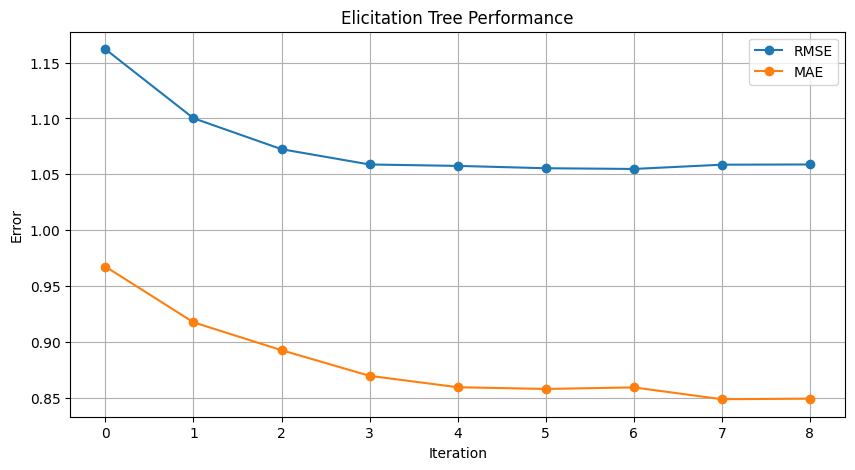

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(approach1_rmse)), approach1_rmse, label='RMSE', marker='o')
plt.plot(range(len(approach1_mae)), approach1_mae, label='MAE', marker='o')
plt.title('Elicitation Tree Performance')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()

# Approach 3

In all iterations, we start from building a one-level tree. If the item is already asked for in one of the last iterations from the user, go to the next level. E.g.
In the first iteration, we build a one-level tree. Then only one item is selected by the tree and is added to the training set.  Prediction and RMSE are computed via SVD.
In the second iteration, we try to build a two-level tree and traverse each user from the root. The first unasked item for each user is added to the training set. Prediction and RMSE are computed via SVD.

- implementation

In each outer iteratiion, we retrain a tree with depth equal to the number of current iteration. 
Then we iteration all depth of the current tree and generate item_user_map for each node in each level. Item_user_map is a dictionary with item as key and list of user as value. For each node, we map item_user_map to path. Path is a dictionary with user as key and item as value. Then for each user, we look up item in his path one by one: If item is not in asked_items, we add it to asked_items and items_to_add. If the item is in asked_items, we skip this item and look for the next item. 


## Questions
what should we do if all items in the user's path has been asked in the previous iteration?

In [ ]:
def elicitation_tree(train, test, X, iteration=8, rid_to_idx=None, cid_to_idx=None):
    rmse, mae = [], []
    
    # Initial training setup
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    all_users = range(train.shape[0])
    
    # Initial model training
    train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    algo = SVD().fit(data_r.build_full_trainset())
    
    # Evaluate initial performance
    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_set = list(zip(test_df['user_id'], test_df['item_id'], test_df['rating']))
    predictions = algo.test(test_set)
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    print(f"Initial RMSE: {rmse[-1]}, Initial MAE: {mae[-1]}")

    # Initialize asked items dictionary
    asked_items = {user_idx: set() for user_idx in all_users}

    # Main elicitation loop
    for current_depth in range(1, iteration+1):
        print(f"\n🚀 Building a {current_depth} depth tree")
        
        # 1. Build tree with current iteration depth
        current_train_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
        pct = Tree(max_depth=current_depth)
        pct.fit(current_train_df, current_train_df)
        pct.print_tree_structure()
        
        # 2. Generate item_user_map for each level
        item_user_map = {}
        for level in range(current_depth):
            parent_nodes = pct.get_nodes_by_level(level)
            
            for node in parent_nodes:
                if node.is_leaf or not isinstance(node.attribute_name, int):
                    continue
                
                item_id = node.attribute_name
                item_idx = cid_to_idx[item_id]
                child_users = []
                
                # Collect users from all children
                for child in node.children:
                    if child and hasattr(child, 'user_ids') and len(child.user_ids) > 0:
                        user_indices = [rid_to_idx[int(u)] for u in child.user_ids if int(u) in rid_to_idx]
                        child_users.extend(user_indices)
                
                # Update item_user_map
                # if item_idx not in item_user_map:
                #    item_user_map[item_idx] = []
                item_user_map[item_idx].extend(child_users)

        # 3. Map item_user_map to path dictionary (user -> items)
        path = defaultdict(list)
        for item_idx, users in item_user_map.items():
            for user_idx in users:
                path[user_idx].append(item_idx)
        print(f"Path: {path}")
       

        # 4. Collect items to add
        items_to_add = defaultdict(list)
        for user_idx in all_users:
            if user_idx in path:
                for item_idx in path[user_idx]:
                    if item_idx not in asked_items[user_idx]:
                        asked_items[user_idx].add(item_idx)
                        items_to_add[user_idx].append(item_idx)
                        break  # Only add first unasked item
        # print all users and their items_to_add
        for user_idx, items in items_to_add.items():
            if len(items) > 0:
                print(f"User {user_idx} has items to add: {items}")
            else:
                print(f"User {user_idx} has no items to add")



        # 5. Update training data
        for user_idx, item_idx in items_to_add.items():
            train_copy[user_idx, item_idx] = X[user_idx, item_idx]
            X_copy[user_idx, item_idx] = 0

        # 6. Retrain and evaluate
        updated_train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(updated_train_df[['user_id', 'item_id', 'rating']], reader)
        algo = SVD().fit(data_r.build_full_trainset())
        
        predictions = algo.test(test_set)
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))

        # print users and item in asked_items and items_to_add together
    for user_idx, items in asked_items.items():
        print(f"User {user_idx} has asked items: {items}")    

    return rmse, mae


In [40]:
approach3 = elicitation_tree(train, test, X_matrix, iteration=6, rid_to_idx=rid_to_idx, cid_to_idx=cid_to_idx)
approach3_rmse = approach3[0]
approach3_mae = approach3[1]
print("Approach 3 RMSE:", approach3_rmse)

RMSE: 1.1617
MAE:  0.9671
Initial RMSE: 1.1616686694270757, Initial MAE: 0.9670912867297053

🚀 Building a 1 depth tree


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
Leaf Node: No
Depth: 0
Item_ID: 32
user_ids: [2, 5, 8, 9, 10, 11, 13, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 42, 44, 45, 48, 49, 53, 58, 59, 62, 65, 73, 75, 78, 82, 90, 92, 93, 97, 101, 102, 103, 107, 117, 118, 119, 123, 127, 129, 130, 131, 133, 134, 136, 137, 139, 146, 147, 148, 149, 150, 151, 156, 157, 161, 162, 163, 166, 169, 173, 175, 178, 179, 181, 186, 187, 190, 192, 193, 195, 198, 199, 202, 203, 204, 205, 208, 210, 212, 214, 216, 220, 223, 224, 225, 229, 230, 235, 237, 238, 240, 242, 245, 249, 255, 258, 259, 260, 261, 262, 264, 267, 268, 270, 271, 272, 273, 274, 278, 284, 285, 287, 293, 295, 300, 301, 302, 303, 305, 306, 307, 308, 309, 310, 314, 319, 321, 323, 326, 327, 329, 331, 333, 335, 336, 337, 338, 339, 340, 342, 343, 346, 349, 351, 352, 355, 366, 368, 372, 376, 377, 380, 385, 386, 390, 392, 396, 398, 402, 403, 406, 408, 409, 411, 412, 415, 419, 424, 425, 426, 429, 435, 436, 438, 

/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None 

✅ Tree built successfully!
Leaf Node: No
Depth: 0
Item_ID: 32
user_ids: [2, 5, 8, 9, 10, 11, 13, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 42, 44, 45, 48, 49, 53, 58, 59, 62, 65, 73, 75, 78, 82, 90, 92, 93, 97, 101, 102, 103, 107, 117, 118, 119, 123, 127, 129, 130, 131, 133, 134, 136, 137, 139, 146, 147, 148, 149, 150, 151, 156, 157, 161, 162, 163, 166, 169, 173, 175, 178, 179, 181, 186, 187, 190, 192, 193, 195, 198, 199, 202, 203, 204, 205, 208, 210, 212, 214, 216, 220, 223, 224, 225, 229, 230, 235, 237, 238, 240, 242, 245, 249, 255, 258, 259, 260, 261, 262, 264, 267, 268, 270, 271, 272, 273, 274, 278, 284, 285, 287, 293, 295, 300, 301, 302, 303, 305, 306, 307, 308, 309, 310, 314, 319, 321, 323, 326, 327, 329, 331, 333, 335, 336, 337, 338, 339, 340, 342, 343, 346, 349, 351, 352, 355, 366, 368, 372, 376, 377, 380, 385, 386, 390, 392, 396, 398, 402, 403, 406, 408, 409, 411, 412, 415, 419, 424, 425, 426, 429, 435, 436, 438, 442, 444, 445, 451, 452, 453, 454, 456, 457, 4

/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None 

✅ Tree built successfully!
Leaf Node: No
Depth: 0
Item_ID: 32
user_ids: [2, 5, 8, 9, 10, 11, 13, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 42, 44, 45, 48, 49, 53, 58, 59, 62, 65, 73, 75, 78, 82, 90, 92, 93, 97, 101, 102, 103, 107, 117, 118, 119, 123, 127, 129, 130, 131, 133, 134, 136, 137, 139, 146, 147, 148, 149, 150, 151, 156, 157, 161, 162, 163, 166, 169, 173, 175, 178, 179, 181, 186, 187, 190, 192, 193, 195, 198, 199, 202, 203, 204, 205, 208, 210, 212, 214, 216, 220, 223, 224, 225, 229, 230, 235, 237, 238, 240, 242, 245, 249, 255, 258, 259, 260, 261, 262, 264, 267, 268, 270, 271, 272, 273, 274, 278, 284, 285, 287, 293, 295, 300, 301, 302, 303, 305, 306, 307, 308, 309, 310, 314, 319, 321, 323, 326, 327, 329, 331, 333, 335, 336, 337, 338, 339, 340, 342, 343, 346, 349, 351, 352, 355, 366, 368, 372, 376, 377, 380, 385, 386, 390, 392, 396, 398, 402, 403, 406, 408, 409, 411, 412, 415, 419, 424, 425, 426, 429, 435, 436, 438, 442, 444, 445, 451, 452, 453, 454, 456, 457, 4

/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None 

✅ Tree built successfully!
Leaf Node: No
Depth: 0
Item_ID: 32
user_ids: [2, 5, 8, 9, 10, 11, 13, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 42, 44, 45, 48, 49, 53, 58, 59, 62, 65, 73, 75, 78, 82, 90, 92, 93, 97, 101, 102, 103, 107, 117, 118, 119, 123, 127, 129, 130, 131, 133, 134, 136, 137, 139, 146, 147, 148, 149, 150, 151, 156, 157, 161, 162, 163, 166, 169, 173, 175, 178, 179, 181, 186, 187, 190, 192, 193, 195, 198, 199, 202, 203, 204, 205, 208, 210, 212, 214, 216, 220, 223, 224, 225, 229, 230, 235, 237, 238, 240, 242, 245, 249, 255, 258, 259, 260, 261, 262, 264, 267, 268, 270, 271, 272, 273, 274, 278, 284, 285, 287, 293, 295, 300, 301, 302, 303, 305, 306, 307, 308, 309, 310, 314, 319, 321, 323, 326, 327, 329, 331, 333, 335, 336, 337, 338, 339, 340, 342, 343, 346, 349, 351, 352, 355, 366, 368, 372, 376, 377, 380, 385, 386, 390, 392, 396, 398, 402, 403, 406, 408, 409, 411, 412, 415, 419, 424, 425, 426, 429, 435, 436, 438, 442, 444, 445, 451, 452, 453, 454, 456, 457, 4

/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None 

✅ Tree built successfully!
Leaf Node: No
Depth: 0
Item_ID: 32
user_ids: [2, 5, 8, 9, 10, 11, 13, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 42, 44, 45, 48, 49, 53, 58, 59, 62, 65, 73, 75, 78, 82, 90, 92, 93, 97, 101, 102, 103, 107, 117, 118, 119, 123, 127, 129, 130, 131, 133, 134, 136, 137, 139, 146, 147, 148, 149, 150, 151, 156, 157, 161, 162, 163, 166, 169, 173, 175, 178, 179, 181, 186, 187, 190, 192, 193, 195, 198, 199, 202, 203, 204, 205, 208, 210, 212, 214, 216, 220, 223, 224, 225, 229, 230, 235, 237, 238, 240, 242, 245, 249, 255, 258, 259, 260, 261, 262, 264, 267, 268, 270, 271, 272, 273, 274, 278, 284, 285, 287, 293, 295, 300, 301, 302, 303, 305, 306, 307, 308, 309, 310, 314, 319, 321, 323, 326, 327, 329, 331, 333, 335, 336, 337, 338, 339, 340, 342, 343, 346, 349, 351, 352, 355, 366, 368, 372, 376, 377, 380, 385, 386, 390, 392, 396, 398, 402, 403, 406, 408, 409, 411, 412, 415, 419, 424, 425, 426, 429, 435, 436, 438, 442, 444, 445, 451, 452, 453, 454, 456, 457, 4

/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/thesis_github/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None 

✅ Tree built successfully!
Leaf Node: No
Depth: 0
Item_ID: 32
user_ids: [2, 5, 8, 9, 10, 11, 13, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 42, 44, 45, 48, 49, 53, 58, 59, 62, 65, 73, 75, 78, 82, 90, 92, 93, 97, 101, 102, 103, 107, 117, 118, 119, 123, 127, 129, 130, 131, 133, 134, 136, 137, 139, 146, 147, 148, 149, 150, 151, 156, 157, 161, 162, 163, 166, 169, 173, 175, 178, 179, 181, 186, 187, 190, 192, 193, 195, 198, 199, 202, 203, 204, 205, 208, 210, 212, 214, 216, 220, 223, 224, 225, 229, 230, 235, 237, 238, 240, 242, 245, 249, 255, 258, 259, 260, 261, 262, 264, 267, 268, 270, 271, 272, 273, 274, 278, 284, 285, 287, 293, 295, 300, 301, 302, 303, 305, 306, 307, 308, 309, 310, 314, 319, 321, 323, 326, 327, 329, 331, 333, 335, 336, 337, 338, 339, 340, 342, 343, 346, 349, 351, 352, 355, 366, 368, 372, 376, 377, 380, 385, 386, 390, 392, 396, 398, 402, 403, 406, 408, 409, 411, 412, 415, 419, 424, 425, 426, 429, 435, 436, 438, 442, 444, 445, 451, 452, 453, 454, 456, 457, 4

In [37]:
item_idx = cid_to_idx[1380]
item_idx

525

In [38]:
user_indices = rid_to_idx[1172]
user_indices

526

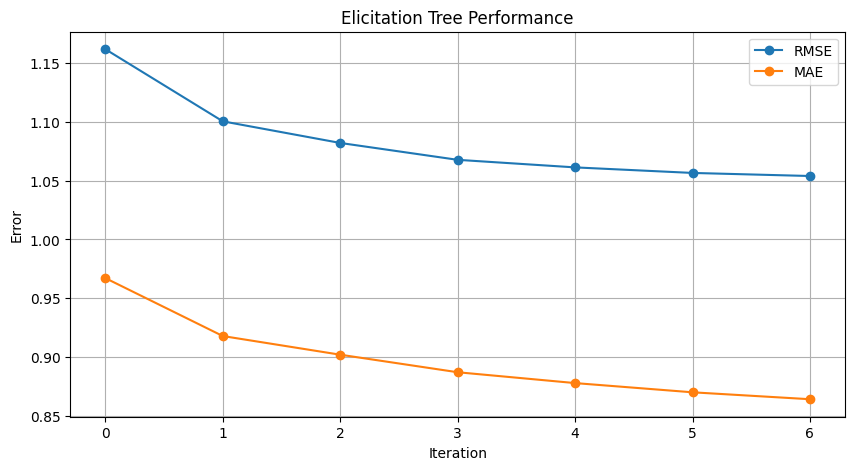

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(approach3_rmse)), approach3_rmse, label='RMSE', marker='o')
plt.plot(range(len(approach3_mae)), approach3_mae, label='MAE', marker='o')
plt.title('Elicitation Tree Performance')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()